In [23]:
import os, glob
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import scipy.stats as stats
import cv2 as cv
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import model_selection as slms, preprocessing as spre
from skimage import measure as meas, feature as feat
from tqdm import tnrange, tqdm_notebook as tqdm
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
plt.style.use("bmh")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [5]:
traindir = 'D:/Kenneth/Documents/VIP/Datasets/fruits-360/Training/'

In [14]:
ban_a, app_a, ora_a = np.load('astar-ban_app_ora.npy')
ban_b, app_b, ora_b = np.load('bstar-ban_app_ora.npy')
ban_e, app_e, ora_e = np.load('ecc-ban_app_ora.npy')

ban_features = np.array([ban_a, ban_b, ban_e]).T
app_features = np.array([app_a, app_b, app_e]).T
ora_features = np.array([ora_a, ora_b, ora_e]).T

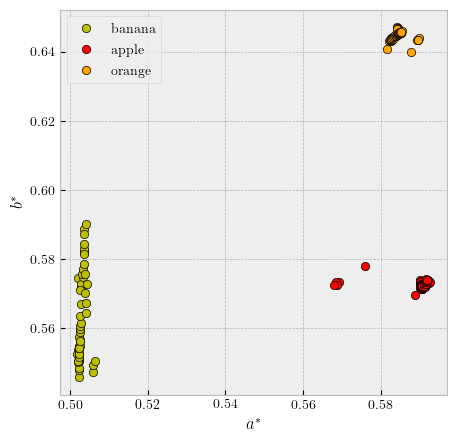

In [19]:
plt.plot(ban_features.T[0], ban_features.T[1], 'yo', mec='k', mew=0.5)
plt.plot(app_features.T[0], app_features.T[1], 'ro', mec='k', mew=0.5)
plt.plot(ora_features.T[0], ora_features.T[1], 'o', color='orange', mec='k', mew=0.5)
plt.legend(['banana', 'apple', 'orange'])
plt.xlabel('$a^*$')
plt.ylabel('$b^*$')
# plt.savefig('ab-space.png', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
class ExpectationMaximization:
    def __init__(self, n_classes,
                 dimensions,
                 epochs=int(1e6), 
                 baseline=0.01):
        self.n_classes = n_classes
        self.dimensions = dimensions
        self.epochs = epochs
        self.baseline = baseline
    
    def _gaussian(self, x, mu, sigma):
        return 1/(2*np.pi)**(self.dimensions/2)/abs(sigma)**(1/2) \
             * np.exp(-1/2 * (x - mu).T.dot(la.inv(sigma)).dot(x - mu))
    
    def _prob_xi_in_l(self, x, mu, sigma):
        num = self.params['P'] * self._gaussian(x, mu, sigma)
        den = self.params['P'].sum() * self._gaussian(x,
                                                      self.params['mu'].sum(),
                                                      self.params['cov'].sum(axis=0)
                                                     )
        return num/den
    
    def train(self, X, cluster_means):
        self.params = dict({'P': 1/(np.ones(self.n_classes)*self.n_classes),
                            'mu': cluster_means,
                            'cov': np.array([np.identity(self.dimensions) \
                                             for _ in range(self.n_classes)])
                           })
        Pnew = np.zeros_like(self.params['P'])
        mu_new = np.zeros_like(self.params['mu'])
        cov_new = np.zeros_like(self.params['cov'])
        for count in tnrange(self.epochs, desc='Epoch'):
            for l in range(self.n_classes):
                P = 0.
                for i in range(len(X)):
                    P += self._prob_xi_in_l(X[i], 
                                            self.params['mu'][l],
                                            self.params['mu'][l]
                                           )
                Pnew[l] = P/len(X)
                
                num, den = 0., 0.
                for i in range(len(X)):
                    num += X[i] * self._prob_xi_in_l(X[i], 
                                                     self.params['mu'][l],
                                                     self.params['mu'][l]
                                                    )
                    den += self._prob_xi_in_l(X[i], 
                                              self.params['mu'][l],
                                              self.params['mu'][l]
                                             )
                mu_new[l] = num/den
            
                num, den = 0., 0.
                for i in range(len(X)):
                    num += self._prob_xi_in_l(X[i], 
                                              self.params['mu'][l],
                                              self.params['mu'][l]
                                             ).dot(X[i] - mu_new[l]).dot(X[i] - mu_new[l]).T
                    den += self._prob_xi_in_l(X[i], 
                                              self.params['mu'][l],
                                              self.params['mu'][l]
                                             )
                cov_new[l] = num/den
            
            new_params = dict({'P': Pnew,
                               'mu': mu_new,
                               'cov': cov_new
                              })
            res = np.array([np.sum((self.params['P'] - new_params['P'])**2),
                            np.sum((self.params['mu'] - new_params['mu'])**2),
                            np.sum((self.params['cov'] - new_params['cov'])**2)
                           ])
            self.params = new_params
            if all(res < self.baseline):
                break

In [42]:
em = ExpectationMaximization(3, 2, baseline=0.1)
em.train(np.column_stack((ban_a, ban_b)), [np.mean([ban_a, ban_b])])

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional